<a href="https://colab.research.google.com/github/Ashikagade333/Ashikagade_INFO5371_Fall2023/blob/main/INFO5731_Assignment_Three_fall2023_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment Three**

In this assignment, you are required to conduct information extraction, semantic analysis based on **the dataset you collected from assignment two**. You may use scipy and numpy package in this assignment.

# **Question 1: Understand N-gram**

(45 points). Write a python program to conduct N-gram analysis based on the dataset in your assignment two:

(1) Count the frequency of all the N-grams (N=3).

(2) Calculate the probabilities for all the bigrams in the dataset by using the fomular count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the **noun phrases** and calculate the relative probabilities of each review in terms of other reviews (abstracts, or tweets) by using the fomular frequency (noun phrase) / max frequency (noun phrase) on the whole dataset. Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).


In [ ]:
pip install pandas nltk


In [ ]:
# Write your code here
import pandas as pd
from nltk.util import ngrams
from collections import Counter
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

file_path = '/content/output.csv'
data = pd.read_csv(file_path)

combined_text = ' '.join(data['review_body'].astype(str))
processed_text = preprocess_text(combined_text)
words = processed_text.split()
trigrams = ngrams(words, 3)
trigram_freq = Counter(trigrams)
for trigram, freq in trigram_freq.most_common(10):
    print(trigram, freq)

('i', 'love', 'it') 1675
('easy', 'to', 'use') 1333
('fire', 'hd', '7') 1264
('love', 'it', 'i') 943
('i', 'love', 'my') 920
('the', 'fire', 'hd') 867
('the', 'kindle', 'fire') 829
('kindle', 'fire', 'hd') 732
('my', 'kindle', 'fire') 679
('this', 'is', 'my') 675


In [ ]:
import pandas as pd
from nltk import bigrams
from collections import Counter
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

file_path = '/content/output.csv'
data = pd.read_csv(file_path)
combined_text = ' '.join(data['review_body'].astype(str))
processed_text = preprocess_text(combined_text)
words = processed_text.split()
bigrams_list = bigrams(words)
bigram_freq = Counter(bigrams_list)
unigram_freq = Counter(words)
bigram_probabilities = {bigram: count / unigram_freq[bigram[0]] for bigram, count in bigram_freq.items()}

for bigram, probability in list(bigram_probabilities.items())[:10]:
    print(f"Bigram: {bigram}, Probability: {probability:.4f}")


Bigram: ('great', 'love'), Probability: 0.0183
Bigram: ('love', 'it'), Probability: 0.4687
Bigram: ('it', 'lots'), Probability: 0.0003
Bigram: ('lots', 'of'), Probability: 0.8759
Bigram: ('of', 'adsbr'), Probability: 0.0001
Bigram: ('adsbr', 'slow'), Probability: 0.1667
Bigram: ('slow', 'processing'), Probability: 0.0126
Bigram: ('processing', 'speedbr'), Probability: 0.0400
Bigram: ('speedbr', 'occasionally'), Probability: 0.3333
Bigram: ('occasionally', 'shuts'), Probability: 0.0185


In [ ]:
import pandas as pd
import nltk
from nltk import pos_tag, word_tokenize
from nltk.chunk.regexp import RegexpParser
from collections import Counter
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

def extract_noun_phrases(text):
    """ Extract noun phrases from a given text """
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    grammar = "NP: {<DT>?<JJ>*<NN.*>+}"
    cp = RegexpParser(grammar)
    tree = cp.parse(tagged)
    return [' '.join(leaf[0] for leaf in tree.leaves()) for subtree in tree.subtrees() if subtree.label() == 'NP']

data = pd.read_csv('/content/output.csv')
data = data.head(100)
data['noun_phrases'] = data['review_body'].apply(extract_noun_phrases)
all_noun_phrases = [phrase for sublist in data['noun_phrases'] for phrase in sublist]
np_frequencies = Counter(all_noun_phrases)
max_frequency = max(np_frequencies.values())
def calculate_relative_frequency(noun_phrases):
    return {np: noun_phrases.count(np) / max_frequency for np in set(noun_phrases)}
data['relative_freq'] = data['noun_phrases'].apply(calculate_relative_frequency)
noun_phrases_list = list(set(all_noun_phrases))  # Convert set to list
table = pd.DataFrame(columns=noun_phrases_list, index=data.index)

for index, row in data.iterrows():
    for np in noun_phrases_list:
        table.at[index, np] = row['relative_freq'].get(np, 0)
print(table)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


   I like everything about it except that I do n't think the battery lasts as long as my other one did .  \
0                                                   0                                                      
1                                                   0                                                      
2                                                   0                                                      
3                                                   0                                                      
4                                                   0                                                      
..                                                ...                                                      
95                                                  0                                                      
96                                                  0                                                      
97                          

# **Question 2: Undersand TF-IDF and Document representation**

(20 points). Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the **documents-terms weights (tf*idf) matrix bold text**.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using **cosine similarity**.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

def preprocess(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_tokens)

data = pd.read_csv('/content/output.csv')
data['processed_reviews'] = data['review_body'].apply(preprocess)

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(data['processed_reviews'])

query = "An Outstanding movie with a haunting performance and best character development"
query_processed = preprocess(query)
query_vector = vectorizer.transform([query_processed])

cosine_similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()

document_ranking = pd.DataFrame(data={'review': data['review_body'], 'similarity': cosine_similarities})
ranked_documents = document_ranking.sort_values(by='similarity', ascending=False)

print(ranked_documents.head(10))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                  review  similarity
16846                        Outstanding    0.375787
13307                       Outstanding!    0.375787
21615                      Outstanding !    0.375787
23004                        Outstanding    0.375787
12855                    outstanding !!!    0.375787
24326                        outstanding    0.375787
29386                Outstanding product    0.327468
24384        Great, outstanding, product    0.310892
11499  Nice, but not outstanding Kindle.    0.308747
7501              Absolutely outstanding    0.305304


# **Question 3: Create your own word embedding model**

(20 points). Use the data you collected for assignment two to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit, bert, or others).

(2) Visualize the word embedding model you created.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

In [ ]:
import gensim
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

def preprocess(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word.isalpha() and word not in stop_words]

data = pd.read_csv('/content/output.csv')
data['processed_reviews'] = data['review_body'].apply(preprocess)

model = Word2Vec(sentences=data['processed_reviews'], vector_size=300, window=5, min_count=1, workers=4)

model.save("word2vec_model.model")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


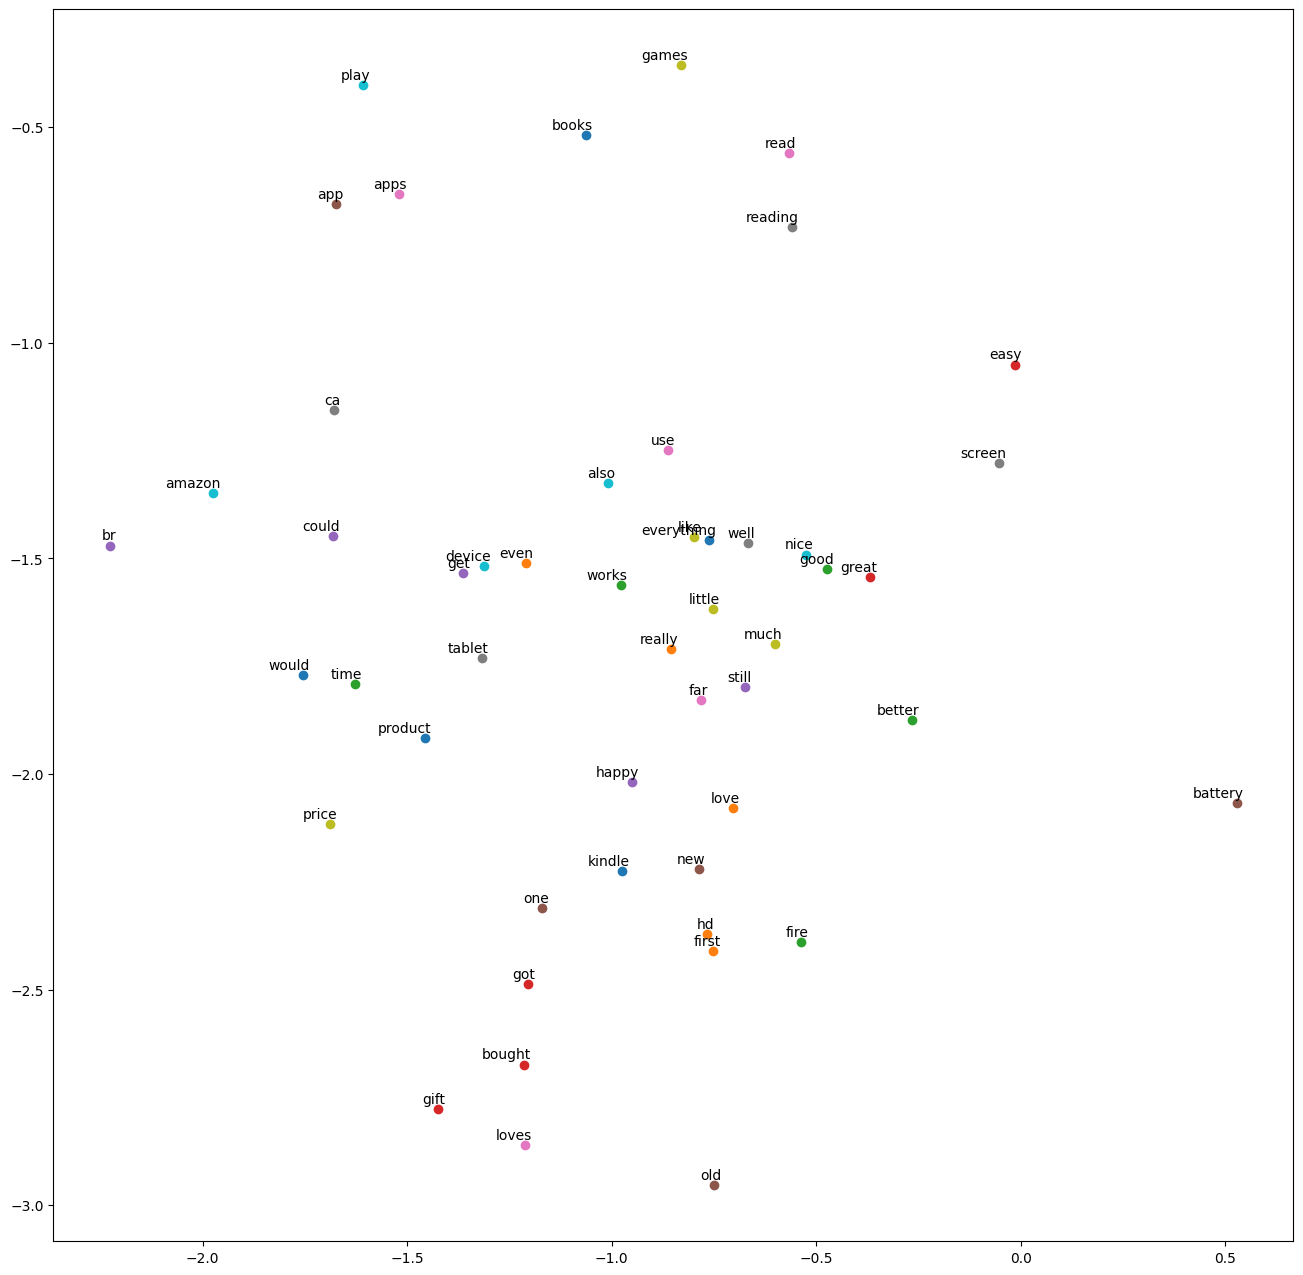

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.index_to_key[:50]:
        tokens.append(model.wv[word])
        labels.append(word)
    tokens_array = np.array(tokens)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens_array)

    x = [value[0] for value in new_values]
    y = [value[1] for value in new_values]
    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

model = Word2Vec.load("word2vec_model.model")
tsne_plot(model)


# **Question 4: Create your own training and evaluation data for sentiment analysis**

(15 points). **You dodn't need to write program for this question!** Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral). Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew. This datset will be used for assignment four: sentiment analysis and text classification.


In [ ]:
# The GitHub link of your final csv file



# Link:



